In [81]:
from data_loader import load_orl
import random
import numpy as np
import torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
data = load_orl()

train, test = data["train"], data["test"]
print(f"Train set: {len(train)} samples")
print(f"Test set: {len(test)} samples")



train_labels = [instance['label'] for instance in data['train']]
test_labels = [instance['label'] for instance in data['test']]

print(f"Train labels: {sorted(set(train_labels))}")
print(f"Test labels: {sorted(set(test_labels))}")

print(f"Missing in train: {set(test_labels) - set(train_labels)}")
print(f"Missing in test: {set(train_labels) - set(test_labels)}")


Train set: 360 samples
Test set: 40 samples
Train labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Test labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Missing in train: set()
Missing in test: set()


In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary

Displaying 2 examples from the ORL training set:


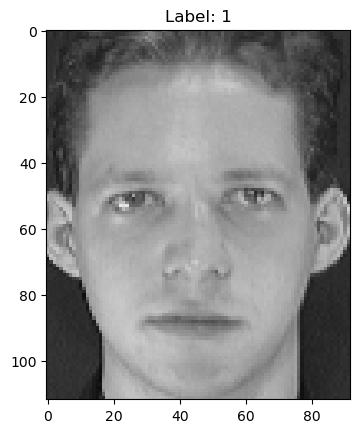

Example 1: Label = 1


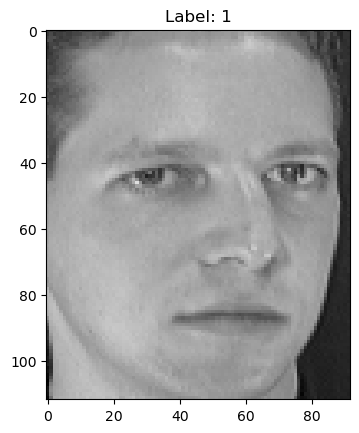

Example 2: Label = 1


In [85]:
train_data = data['train']

print("Displaying 2 examples from the ORL training set:")
for i in range(2):
    instance = train_data[i]
    image_matrix = instance['image']
    image_label = instance['label']

    plt.imshow(image_matrix, cmap='gray')
    plt.title(f"Label: {image_label}")
    plt.show()
    print(f"Example {i+1}: Label = {image_label}")

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#ablation: originally only 2 layers: had 87.5% acc. Adding 1 conv layer, batch norm, dropout, and using cross entropy loss increased it to 92.5%.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # output: 16 x 112 x 92 --> maxPool: 16 x 56 x 46
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # output: 32 x 56 x 46 --> maxPool: 32 x 28 x 23
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # output: 64 x 28 x 23 --> maxPool: 64 x 14 x 11
        self.bn3 = nn.BatchNorm2d(64)

        # compute flatten size: 64 * 14 * 11 = 41216
        self.fc1 = nn.Linear(64 * 14 * 11, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 40)  # 40 classes

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        #print(x.shape)  # Debug shape before flattening

        
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [89]:
def prepare_data(raw_data, batch_size=16):
    # Step 1: Extract images and labels
    images = np.array([item['image'] for item in raw_data]).astype(np.float32)
    labels = np.array([item['label']-1 for item in raw_data]).astype(np.int64)

    # Step 2: Ensure the correct shape: swap height and width
    images = images.reshape(-1, 3, 112, 92)  # Ensure that the shape is (N, 3, 112, 92)
    
    # Use only the R channel (channel 0 in the RGB image)
    images = images[:, 0, :, :]  # Select the first channel (R channel)

    # Step 3: Normalize pixel values to [0, 1]
    images /= 255.0

    # Step 4: Reshape to (N, 1, 112, 92) for CNN input
    images = images.reshape(-1, 1, 112, 92)

    # Step 5: Convert to PyTorch tensors
    tensor_images = torch.from_numpy(images)
    tensor_labels = torch.from_numpy(labels)

    # Step 6: Create dataset and dataloader
    dataset = TensorDataset(tensor_images, tensor_labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

# Load raw data
data = load_orl()

# Prepare loaders
train_loader = prepare_data(data['train'])
test_loader = prepare_data(data['test'])

In [91]:
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

def train(model, train_loader, num_epochs=20):
    model.train()  # training mode
    epoch_losses = []
    loss_history = []  # To store individual batch losses

    for epoch in range(num_epochs):
        running_loss = 0.0  
        epoch_total_loss = 0.0 
        num_batches = 0  

        for batch_idx, (inputs, labels) in enumerate(train_loader):
         
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track losses
            running_loss += loss.item()
            epoch_total_loss += loss.item()
            loss_history.append(loss.item())
            num_batches += 1

            # Print loss for every 5 batches
            if batch_idx % 5 == 4:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
                running_loss = 0.0  # Reset running loss

        # Calculate and print average loss for the current epoch
        avg_loss = epoch_total_loss / num_batches
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    print("Finished Training")
    return epoch_losses, loss_history


Using device: cpu


In [93]:
# Train the model
train_losses, loss_history = train(model, train_loader, num_epochs=30)



Epoch [1/30], Batch [5/23], Loss: 0.2450
Epoch [1/30], Batch [10/23], Loss: 0.1941
Epoch [1/30], Batch [15/23], Loss: 0.1761
Epoch [1/30], Batch [20/23], Loss: 0.1610
Epoch [1/30], Average Loss: 3.8002
Epoch [2/30], Batch [5/23], Loss: 0.1420
Epoch [2/30], Batch [10/23], Loss: 0.1314
Epoch [2/30], Batch [15/23], Loss: 0.1331
Epoch [2/30], Batch [20/23], Loss: 0.1237
Epoch [2/30], Average Loss: 2.6942
Epoch [3/30], Batch [5/23], Loss: 0.1127
Epoch [3/30], Batch [10/23], Loss: 0.1024
Epoch [3/30], Batch [15/23], Loss: 0.0992
Epoch [3/30], Batch [20/23], Loss: 0.1034
Epoch [3/30], Average Loss: 2.0327
Epoch [4/30], Batch [5/23], Loss: 0.0795
Epoch [4/30], Batch [10/23], Loss: 0.0824
Epoch [4/30], Batch [15/23], Loss: 0.0844
Epoch [4/30], Batch [20/23], Loss: 0.0639
Epoch [4/30], Average Loss: 1.5499
Epoch [5/30], Batch [5/23], Loss: 0.0689
Epoch [5/30], Batch [10/23], Loss: 0.0636
Epoch [5/30], Batch [15/23], Loss: 0.0591
Epoch [5/30], Batch [20/23], Loss: 0.0578
Epoch [5/30], Average Los

In [98]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move to device
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    print(f"Accuracy on test set: {accuracy:.2f}%")
    print("\n Classification Report:")
    target_names = [str(i) for i in range(40)]
    print(classification_report(all_labels, all_preds, target_names=target_names))

# Usage
print("\nStarting evaluation...")
evaluate_model(model, test_loader)


Starting evaluation...
Accuracy on test set: 92.50%

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
   

/Users/reetibandyopadhyay/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reetibandyopadhyay/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reetibandyopadhyay/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

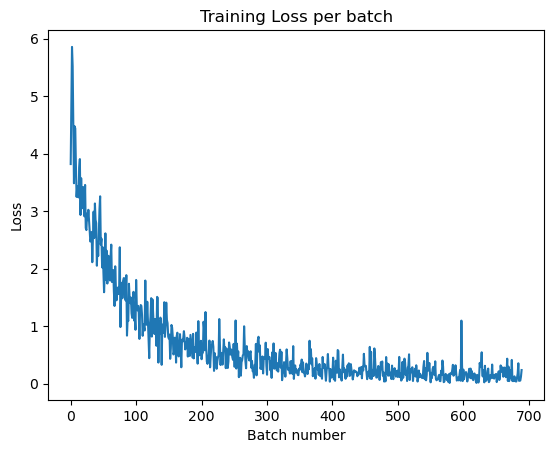

In [100]:
plt.figure()
plt.plot(loss_history)
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Training Loss per batch')
plt.show()

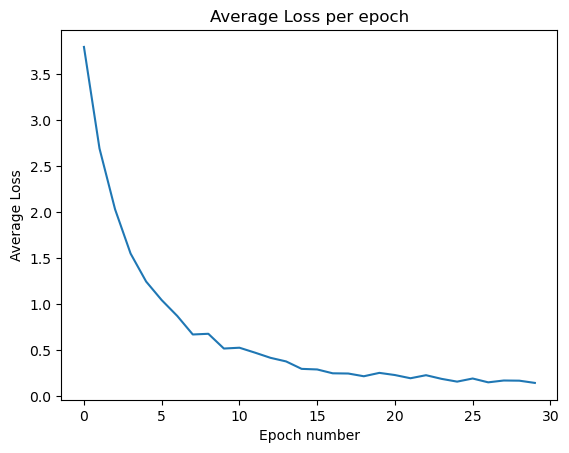

In [102]:
plt.figure()
plt.plot(train_losses)
plt.xlabel('Epoch number')
plt.ylabel('Average Loss')
plt.title('Average Loss per epoch')
plt.show()